In [ ]:
#!pip uninstall -y fbprophet
#!pip uninstall -y pystan
#!pip install fbprophet
#!pip install pystan==2.19.1.1

In [1]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
df = pd.read_excel("/content/Dados Históricos - Ibovespa.xlsx")

In [5]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2019-01-02,134185,134194,134389,133832,"7,81M",-0.0001
1,2019-01-03,134194,133523,134195,133328,"6,17M",0.0049
2,2019-01-04,133533,132753,133645,132753,"5,15M",0.0059
3,2019-01-07,132753,132182,133035,132094,"8,23M",0.0043
4,2019-01-08,132182,130826,132277,130822,"8,68M",0.0105


In [6]:
df['Data'] = pd.to_datetime(df['Data'])

In [7]:
df.drop(columns=['Abertura','Máxima','Mínima','Vol.','Var%'], inplace=True)

In [8]:
df.head()

,Data,Último
0,2019-01-02,134185
1,2019-01-03,134194
2,2019-01-04,133533
3,2019-01-07,132753
4,2019-01-08,132182


In [9]:
ultimo_data = df['Último'].values
ultimo_data = ultimo_data.reshape(-1,1) #transformar em array

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ultimo_data)
ultimo_data = scaler.transform(ultimo_data)

In [13]:
split_percent = 0.80
split = int(split_percent*len(ultimo_data))

ultimo_train = ultimo_data[:split]
ultimo_test = ultimo_data[split:]

date_train = df['Data'][:split]
date_test = df['Data'][split:]

print(len(ultimo_train))
print(len(ultimo_test))

993
249


In [15]:

look_back = 10

train_generator = TimeseriesGenerator(ultimo_train, ultimo_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(ultimo_test, ultimo_test, length=look_back, batch_size=1)

In [16]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
50/50 [==============================] - 3s 8ms/step - loss: 0.1096 - mean_squared_error: 0.1096
Epoch 2/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 3/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 4/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 5/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 6/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 7/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 8/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 9/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 10/20
50/50 [=====

In [17]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

239/239 [==============================] - 3s 7ms/step - loss: 5.6942e-04 - mean_squared_error: 5.6942e-04
Erro Quadrático Médio 0.0005694181309081614


In [19]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(ultimo_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')


239/239 [==============================] - 2s 7ms/step
MAPE: 2.0463


In [20]:
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.023862483753963278


In [22]:
prediction = model.predict(test_generator)

ultimo_train = ultimo_train.reshape((-1))
ultimo_test = ultimo_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = ultimo_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = ultimo_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da Ibovespa",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

239/239 [==============================] - 1s 5ms/step


In [23]:
df.head()

,Data,Último
0,2019-01-02,134185
1,2019-01-03,134194
2,2019-01-04,133533
3,2019-01-07,132753
4,2019-01-08,132182


In [24]:
df = df_ibovespa = df

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    1242 non-null   datetime64[ns]
 1   Último  1242 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.5 KB


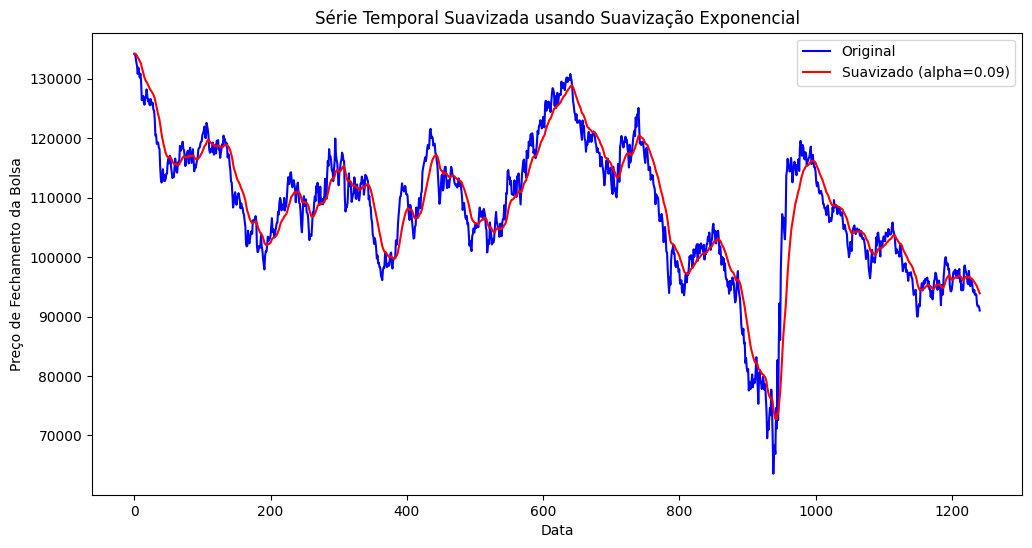

In [30]:
alpha = 0.09

df['Smoothed_Último'] = df['Último'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Último'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Último'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento da Bolsa')
plt.legend()
plt.show()

In [31]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df['Smoothed_Último'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.2965836354258746
p-value: 0.015031878459098017
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -3.2965836354258746
Valor-p: 0.015031878459098017
Valores Críticos:
   1%: -3.4356646522289815
   5%: -2.863886926389418
   10%: -2.568019536239491


In [32]:
df.drop(columns=['Último'], inplace=True)
df.head()

,Data,Smoothed_Último
0,2019-01-02,134185.000000
1,2019-01-03,134185.810000
2,2019-01-04,134127.057100
3,2019-01-07,134003.391961
4,2019-01-08,133839.466685


In [33]:
ultimo_data = df['Smoothed_Último'].values
ultimo_data = ultimo_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ultimo_data)
ultimo_data = scaler.transform(ultimo_data)

In [34]:
ultimo_data

array([[0.99998681],
       [1.        ],
       [0.99904304],
       ...,
       [0.35270151],
       [0.34847865],
       [0.34382667]])

In [36]:
split_percent = 0.80
split = int(split_percent*len(ultimo_data))

ultimo_train = ultimo_data[:split]
ultimo_test = ultimo_data[split:]

date_train = df['Data'][:split]
date_test = df['Data'][split:]

print(len(ultimo_train))
print(len(ultimo_test))

993
249


In [38]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(ultimo_train, ultimo_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(ultimo_test, ultimo_test, length=look_back, batch_size=1)

In [39]:
np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
50/50 [==============================] - 3s 10ms/step - loss: 0.1985 - mean_squared_error: 0.1985
Epoch 2/100
50/50 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 3/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 9.3607e-04 - mean_squared_error: 9.3607e-04
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 8.2241e-04 - mean_squared_error: 8.2241e-04
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 5.5575e-04 - mean_squared_error: 5.5575e-04
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 6.3818e-04 - mean_squared_error: 6.3818e-04
Epoch 8/100
50/50 [==============================] - 0s 5ms/step - loss: 5.5562e-04 - mean_squared_error: 5.5562e-04
Epoch 9/100
50/50 [==============================] - 0s 6ms/step - loss: 6.9223e-04 - 

In [41]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(ultimo_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")

244/244 [==============================] - 1s 5ms/step
MAPE: 0.44%


In [42]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

244/244 [==============================] - 2s 5ms/step - loss: 1.2489e-04 - mean_squared_error: 1.2489e-04
Erro Quadrático Médio: 0.00012489189975894988


In [43]:
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.011175504452101921


In [44]:
prediction = model.predict(test_generator)

ultimo_train = ultimo_train.reshape((-1))
ultimo_test = ultimo_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = ultimo_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = ultimo_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da IBOVESPA",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

244/244 [==============================] - 1s 4ms/step


In [45]:
ultimo_data = ultimo_data.reshape((-1))


def predict(num_prediction, model):
    prediction_list = ultimo_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df['Data'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 78ms/step


In [46]:
trace1 = go.Scatter(
    x = date_test,
    y = ultimo_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast Ibovespa",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [48]:
df = pd.DataFrame(df)
df_past = df[['Data','Smoothed_Último']]
df_past.rename(columns={'Smoothed_Último': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Data'] = pd.to_datetime(df_past['Data'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

,Data,Actual,Forecast
0,2019-01-02,134185.0000,NaN
1,2019-01-03,134185.8100,NaN
2,2019-01-04,134127.0571,NaN


In [49]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [50]:
df_future = pd.DataFrame(columns=['Data', 'Actual', 'Forecast'])
df_future['Data'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

,Data,Actual,Forecast
0,2023-12-28,NaN,93899.832673
1,2023-12-29,NaN,94594.092477
2,2023-12-30,NaN,94680.911022
3,2023-12-31,NaN,94869.859237
4,2024-01-01,NaN,95087.153528


In [51]:
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Data')
results.head()

,Actual,Forecast
Data,,
2019-01-02,134185.000000,NaN
2019-01-03,134185.810000,NaN
2019-01-04,134127.057100,NaN
2019-01-07,134003.391961,NaN
2019-01-08,133839.466685,NaN


In [52]:
results.tail()

,Actual,Forecast
Data,,
2024-01-08,NaN,96595.883053
2024-01-09,NaN,96814.494744
2024-01-10,NaN,97034.368944
2024-01-11,NaN,97255.262300
2024-01-12,NaN,97476.746657


In [55]:
results2023 =  results.loc['2023-01-01':]

In [57]:
plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast Ibovespa'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

import plotly as ply
ply.offline.plot(fig)

'temp-plot.html'